In [18]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from matplotlib import gridspec
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from torchvision import datasets
from torchvision import transforms

In [2]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv('Datasets/Ames.csv', header=None, delimiter=r"\s+", names=column_names)

In [3]:
features = torch.from_numpy(df.loc[:, df.columns != 'MEDV'].values).float()

In [4]:
features[0]

tensor([6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01, 6.5750e+00,
        6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02, 1.5300e+01, 3.9690e+02,
        4.9800e+00])

In [5]:
targets = torch.from_numpy(df['MEDV'].values).float()

In [6]:
targets[0]

tensor(24.)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(features,targets,test_size=0.2)

In [8]:
class Perceptron(torch.nn.Module):
    def __init__(self,input_dim, num_layers,
                 hidden_dim, output_dim, p=0.0, device='cpu'):
        super(Perceptron,self).__init__()
        self.layers = torch.nn.Sequential(torch.nn.Flatten(start_dim=-1))
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module(f"layer{i}",
                                   torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module(f"relu{i}", torch.nn.ReLU())
            self.layers.add_module(f"dropout{i}", torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        self.layers.add_module('classifier',
                              torch.nn.Linear(prev_size, output_dim))
        self.to(device)
    def forward(self, input):
        return self.layers(input).squeeze(dim=-1)

model = Perceptron(num_layers=1,hidden_dim=20, input_dim=13, output_dim=1)
model

Perceptron(
  (layers): Sequential(
    (0): Flatten(start_dim=-1, end_dim=-1)
    (layer0): Linear(in_features=13, out_features=20, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [9]:
model(features[0:2])

tensor([49.2917, 42.8888], grad_fn=<SqueezeBackward1>)

In [10]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        x = self.x_train[idx]
        y = self.y_train[idx]
        return x, y

train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

In [11]:
def testing(model, dataset):
    model.eval()
    generator = torch.utils.data.DataLoader(dataset,batch_size=64,
                                            pin_memory=True)
    pred = []
    real = []
    for x,y in generator:
        pred.extend(model(x).detach().numpy().tolist())
        real.extend(y.detach().numpy().tolist())
    return np.sqrt(np.mean((np.array(real)-np.array(pred))**2))

In [12]:
epochs = 1000
optim = torch.optim.Adam(model.parameters(), lr=0.0001,)
loss_function = torch.nn.MSELoss()
list_of_train_error = [testing(model, train_dataset)]
list_of_test_error = [testing(model, test_dataset)]

iterator = tqdm(range(epochs))
for epoch in iterator:
    generator = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                            batch_size=16, pin_memory=True)
    for batch_x, batch_y in generator:
        optim.zero_grad()
        model.train()
        output = model(batch_x)
        loss = loss_function(output, batch_y)
        loss.backward()
        optim.step()
    list_of_train_error.append(testing(model, train_dataset))
    list_of_test_error.append(testing(model, test_dataset))
    iterator.set_postfix({'train': round (list_of_train_error [-1], 2),
                          'test':round (list_of_test_error[-1], 2)})

  0%|          | 0/1000 [00:00<?, ?it/s]

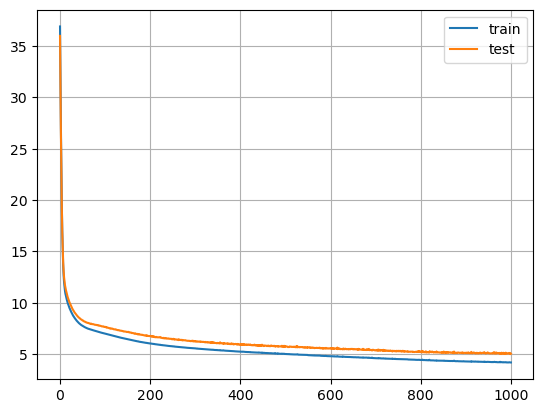

In [13]:
plt.plot(list_of_train_error,label='train')
plt.plot(list_of_test_error,label='test')
plt.grid()
plt.legend(loc='best')

In [14]:
ns = list(range(1, x_train.shape[1]))

scores_train = []
scores_test = []
for n in tqdm(ns):
    pca = PCA(n)
    x_train_low = pca.fit_transform(x_train)
    x_test_low = pca.transform(x_test)
    y_train_np = y_train.numpy()
    y_test_np = y_test.numpy()
    w = np.linalg.inv(x_train_low.T@x_train_low)@x_train_low.T@y_train_np
    scores_train.append(np.mean((x_train_low@w-y_train_np)**2))
    scores_test.append(np.mean((x_test_low@w-y_test_np)**2))

  0%|          | 0/12 [00:00<?, ?it/s]

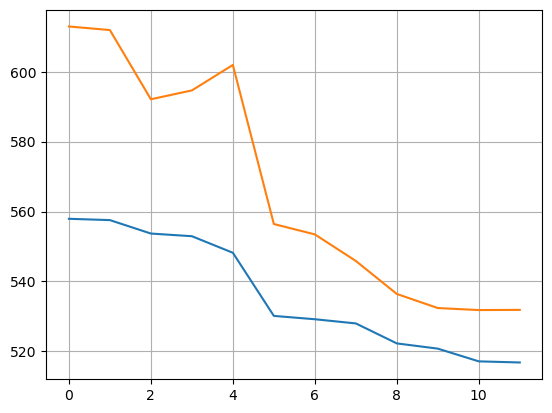

In [15]:
plt.plot(scores_train)
plt.plot(scores_test)
plt.grid()

In [21]:
X, Y = make_classification(n_samples=400, n_features=2,
                          n_informative=2, n_classes=2,
                          n_redundant=0,
                          n_clusters_per_class=1,
                          random_state=0)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,
                                                 test_size=100,
                                                 random_state=0)
X_train_val,X_test_val,Y_train_val,Y_test_val = train_test_split(X_train,
                                                                Y_train,
                                                                test_size=100,
                                                                random_state=0)

In [29]:
model = SVC(probability=True)
_ = model.fit(X_train_val,Y_train_val)
fpr, tpr, thresholds = roc_curve(
    Y_test_val,model.predict_proba(X_test_val)[:,1],pos_label=1)

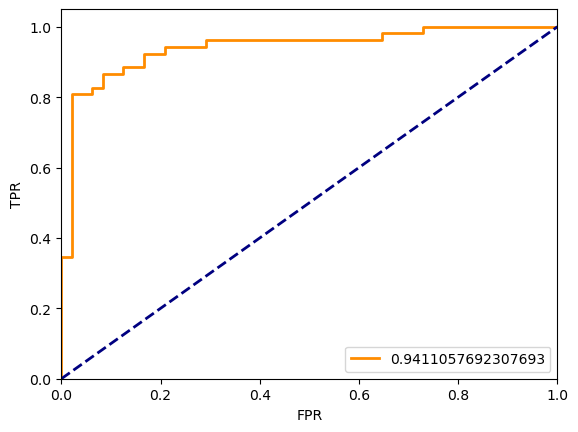

In [30]:
plt.plot(fpr,tpr,color='darkorange',
        lw=2,label=f"{auc(fpr,tpr)}")
plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')

0.4246900185137298

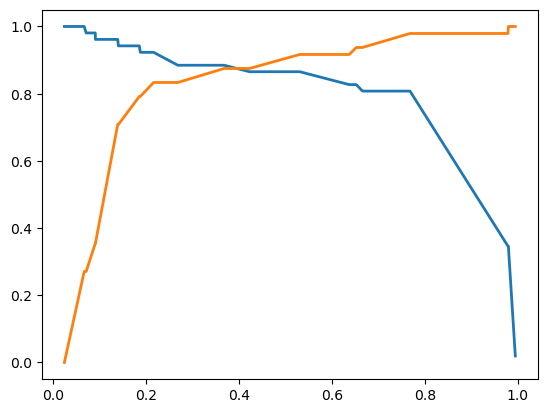

In [32]:
plt.plot(thresholds,tpr,lw=2,label='tpr')
plt.plot(thresholds,1-fpr,lw=2,label='1-fpr')
threshold = tresholds[np.argmin((tpr+fpr-1)**2)]
threshold

In [35]:
print(classification_report(Y_test,model.predict_proba(X_test)[:,1] > threshold))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84        45
           1       0.91      0.78      0.84        55

    accuracy                           0.84       100
   macro avg       0.84      0.85      0.84       100
weighted avg       0.85      0.84      0.84       100

